In [4]:
import pandas as pd

In [5]:
pd.__version__

'2.2.3'

In [32]:
def read_dataframe(df):
    
    df = df.sample(n=10000, random_state=1)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    negative_durations = df[df['duration'] < 0]

    df = df[df['duration'] >= 0]

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [33]:
train = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-01.parquet')

In [34]:
validation = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-02.parquet')

In [35]:
train_df = read_dataframe(train)

In [10]:
train_df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee', 'duration'],
      dtype='object')

In [36]:
val_df = read_dataframe(validation)

In [37]:
(len(train_df),len(val_df))

(9777, 9776)

In [38]:
train_df['PU_DO'] = train_df['PULocationID'] + '_' + train_df['DOLocationID']
val_df['PU_DO'] = val_df['PULocationID'] + '_' + val_df['DOLocationID']

In [39]:
categorical = ['PU_DO']
numerical = ['fare_amount','total_amount','trip_distance']


In [29]:
# correlation_matrix = df[numerical].corr()

# # Plotting the correlation heatmap
# plt.figure(figsize=(12, 8))
# sns.heatmap(df[['duration']], annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
# plt.title('Correlation between Duration and Other Numerical Features')
# plt.show()


In [40]:
from sklearn.feature_extraction import DictVectorizer

In [41]:
dv = DictVectorizer()

train_dicts = train_df[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = val_df[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [42]:
target = 'duration'
y_train = train_df[target].values
y_val = val_df[target].values

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

In [44]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

np.float64(5.115013343915545)

Text(0, 0.5, 'Density')

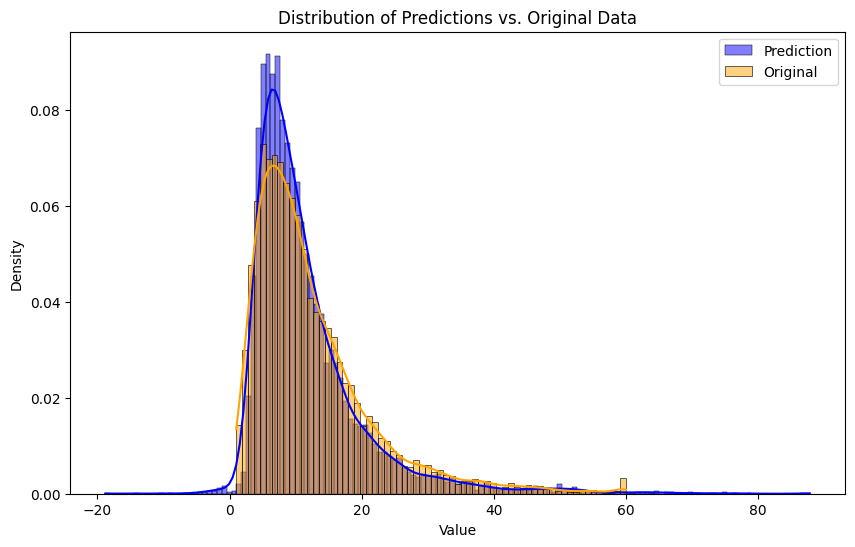

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# Plotting predictions
sns.histplot(y_pred[:100000], color='blue', label='Prediction', kde=True, stat='density', alpha=0.5)

# Plotting original data
sns.histplot(y_val[:100000], color='orange', label='Original', kde=True, stat='density', alpha=0.5)

# Adding legend and labels
plt.legend()
plt.title('Distribution of Predictions vs. Original Data')
plt.xlabel('Value')
plt.ylabel('Density')

In [46]:
import pickle
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv,lr),f_out)

In [27]:
# import mlflow

# mlflow.set_tracking_uri("sqlite:///mlflow.db")
# mlflow.set_experiment("nyc_taxi_experiment")

2024/09/27 19:50:16 INFO mlflow.tracking.fluent: Experiment with name 'nyc_taxi_experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='/workspaces/mlops/01-intro/mlruns/1', creation_time=1727466616327, experiment_id='1', last_update_time=1727466616327, lifecycle_stage='active', name='nyc_taxi_experiment', tags={}>

In [47]:
import xgboost as xgb

In [48]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [49]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [52]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=200,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [53]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=8,
    trials=Trials()
)

[0]	validation-rmse:5.89978                          
  0%|          | 0/8 [00:00<?, ?trial/s, best loss=?]

/workspaces/mlops/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:52:58] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:4.47598                          
[2]	validation-rmse:3.92990                          
[3]	validation-rmse:3.79655                          
[4]	validation-rmse:3.71060                          
[5]	validation-rmse:3.69980                          
[6]	validation-rmse:3.69636                          
[7]	validation-rmse:3.68364                          
[8]	validation-rmse:3.70693                          
[9]	validation-rmse:3.72525                          
[10]	validation-rmse:3.72349                         
[11]	validation-rmse:3.73016                         
[12]	validation-rmse:3.74147                         
[13]	validation-rmse:3.76630                         
[14]	validation-rmse:3.78237                         
[15]	validation-rmse:3.77592                         
[16]	validation-rmse:3.78022                         
[17]	validation-rmse:3.77999                         
[18]	validation-rmse:3.78873                         
[19]	validation-rmse:3.79458

/workspaces/mlops/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:53:07] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.41553                                                    
[2]	validation-rmse:6.71535                                                    
[3]	validation-rmse:6.14242                                                    
[4]	validation-rmse:5.66931                                                    
[5]	validation-rmse:5.28354                                                    
[6]	validation-rmse:4.97329                                                    
[7]	validation-rmse:4.73182                                                    
[8]	validation-rmse:4.53493                                                    
[9]	validation-rmse:4.37899                                                    
[10]	validation-rmse:4.25046                                                   
[11]	validation-rmse:4.15737                                                   
[12]	validation-rmse:4.08207                                                   
[13]	validation-rmse:4.02226            

/workspaces/mlops/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:53:17] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.44625                                                   
[1]	validation-rmse:7.74022                                                   
[2]	validation-rmse:7.12165                                                   
[3]	validation-rmse:6.59550                                                   
[4]	validation-rmse:6.13535                                                   
[5]	validation-rmse:5.74668                                                   
[6]	validation-rmse:5.40967                                                   
[7]	validation-rmse:5.13586                                                   
[8]	validation-rmse:4.88774                                                   
[9]	validation-rmse:4.68247                                                   
[10]	validation-rmse:4.50993                                                  
[11]	validation-rmse:4.37207                                                  
[12]	validation-rmse:4.25530                        

/workspaces/mlops/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:53:38] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.75770                                                    
[1]	validation-rmse:5.33012                                                    
[2]	validation-rmse:4.56150                                                    
[3]	validation-rmse:4.16164                                                    
[4]	validation-rmse:3.97592                                                    
[5]	validation-rmse:3.86418                                                    
[6]	validation-rmse:3.81434                                                    
[7]	validation-rmse:3.79074                                                    
[8]	validation-rmse:3.77471                                                    
[9]	validation-rmse:3.77165                                                    
[10]	validation-rmse:3.77200                                                   
[11]	validation-rmse:3.76630                                                   
[12]	validation-rmse:3.76702            

/workspaces/mlops/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:53:45] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:4.90621                                                    
[3]	validation-rmse:4.35925                                                    
[4]	validation-rmse:4.03971                                                    
[5]	validation-rmse:3.85164                                                    
[6]	validation-rmse:3.74963                                                    
[7]	validation-rmse:3.67140                                                    
[8]	validation-rmse:3.64645                                                    
[9]	validation-rmse:3.61434                                                    
[10]	validation-rmse:3.60571                                                   
[11]	validation-rmse:3.58323                                                   
[12]	validation-rmse:3.57675                                                   
[13]	validation-rmse:3.58823                                                   
[14]	validation-rmse:3.58561            

/workspaces/mlops/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:53:49] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:4.13501                                                    
[2]	validation-rmse:3.93419                                                    
[3]	validation-rmse:3.91267                                                    
[4]	validation-rmse:3.88767                                                    
[5]	validation-rmse:3.90921                                                    
[6]	validation-rmse:3.90794                                                    
[7]	validation-rmse:3.90357                                                    
[8]	validation-rmse:3.90353                                                    
[9]	validation-rmse:3.90159                                                    
[10]	validation-rmse:3.90138                                                   
[11]	validation-rmse:3.90173                                                   
[12]	validation-rmse:3.90106                                                   
[13]	validation-rmse:3.90061            

/workspaces/mlops/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:53:51] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:5.54055                                                    
[2]	validation-rmse:4.69643                                                    
[3]	validation-rmse:4.22971                                                    
[4]	validation-rmse:4.00272                                                    
[5]	validation-rmse:3.89098                                                    
[6]	validation-rmse:3.82672                                                    
[7]	validation-rmse:3.78713                                                    
[8]	validation-rmse:3.78140                                                    
[9]	validation-rmse:3.77328                                                    
[10]	validation-rmse:3.76887                                                   
[11]	validation-rmse:3.77522                                                   
[12]	validation-rmse:3.78545                                                   
[13]	validation-rmse:3.78990            

/workspaces/mlops/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:54:03] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:6.49554                                                    
[2]	validation-rmse:5.64087                                                    
[3]	validation-rmse:5.02311                                                    
[4]	validation-rmse:4.57468                                                    
[5]	validation-rmse:4.27879                                                    
[6]	validation-rmse:4.08180                                                    
[7]	validation-rmse:3.94460                                                    
[8]	validation-rmse:3.86422                                                    
[9]	validation-rmse:3.79297                                                    
[10]	validation-rmse:3.74956                                                   
[11]	validation-rmse:3.71922                                                   
[12]	validation-rmse:3.70684                                                   
[13]	validation-rmse:3.69613            

learning_rate
0.2990328792427093
max_depth
46
min_child_weight
14.14890702819989
objective
reg:linear
reg_alpha
0.019914432077746316
reg_lambda
0.06610735740904622
seed
42

In [55]:
params = {
    'learning_rate' : 0.2990328792427093,
    "max_depth" : 46,
    "min_child_weight" : 14.14890702819989,
    "objective" : "reg:linear",
    "reg_alpha" : 0.019914432077746316,
    "reg_lambda" : 0.06610735740904622,
    "seed" : 42

}

mlflow.xgboost.autolog()

booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=200,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )

2024/09/27 20:09:33 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c91c711a7b284ff88fce3540933d1fa0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[0]	validation-rmse:7.12835
[1]	validation-rmse:5.78211


/workspaces/mlops/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:09:33] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[2]	validation-rmse:4.90621
[3]	validation-rmse:4.35925
[4]	validation-rmse:4.03971
[5]	validation-rmse:3.85164
[6]	validation-rmse:3.74963
[7]	validation-rmse:3.67140
[8]	validation-rmse:3.64645
[9]	validation-rmse:3.61434
[10]	validation-rmse:3.60571
[11]	validation-rmse:3.58323
[12]	validation-rmse:3.57675
[13]	validation-rmse:3.58823
[14]	validation-rmse:3.58561
[15]	validation-rmse:3.58457
[16]	validation-rmse:3.58426
[17]	validation-rmse:3.58022
[18]	validation-rmse:3.57146
[19]	validation-rmse:3.57633
[20]	validation-rmse:3.57341
[21]	validation-rmse:3.57733
[22]	validation-rmse:3.57364
[23]	validation-rmse:3.58414
[24]	validation-rmse:3.59124
[25]	validation-rmse:3.59536
[26]	validation-rmse:3.59899
[27]	validation-rmse:3.60629
[28]	validation-rmse:3.60158
[29]	validation-rmse:3.60301
[30]	validation-rmse:3.60089
[31]	validation-rmse:3.60440
[32]	validation-rmse:3.60894
[33]	validation-rmse:3.61408
[34]	validation-rmse:3.62021
[35]	validation-rmse:3.62276
[36]	validation-rmse:3

2024/09/27 20:09:38 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/09/27 20:09:38 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/mlops/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:09:38] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2024/09/27 20:09:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
